# Automatizacion de busqueda de hyperparámetros 

Voy a hacerlo todo con clases, así será mas sencillo ahorrar memoria, o debería. 

Idealmente esto lo ejecutaria con papermill


In [6]:
#import libraries
import sys 
sys.path.append("..")

import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from model import AnomalyTransformer
import gc
from torch import optim

from torch.utils.data import DataLoader,Dataset

# DATA

In [7]:
class Data_anomSine(Dataset):
    def __init__(self, length=100, amp=1, sf=0.1, f=2, phase=0, anoms=1, magnitud=None, window_size=100):
        super().__init__()
        
        sine_wave = Data_anomSine.sinne(length, amp, sf, f, phase)
        sine_wave_with_anom = Data_anomSine.add_global_anom(sine_wave, anoms, magnitud)
        self.array = Data_anomSine.windowed_view(sine_wave_with_anom, window_size)
        self.array = torch.from_numpy(self.array).unsqueeze(-1)

    def __len__(self):
        return self.array.shape[0]

    def __getitem__(self, index):
        return self.array[index]

    @staticmethod
    def sinne(length=100, amp=1, sf=0.1, f=2, phase=0):
        x = torch.arange(0, length * sf, sf)
        return amp * torch.sin(x * sf * 2 * torch.pi / f + phase)

    @staticmethod
    def add_global_anom(x, anoms=1, magnitud=None):
        x = x.to(float)
        if magnitud is None:
            magnitud = x.max().item() - x.min().item()
        index = torch.from_numpy(np.random.choice(np.arange(0, x.size()[0]), size=anoms, replace=False))
        x[index] = torch.from_numpy(magnitud * np.random.randn(anoms)) + x[index]
        return x

    @staticmethod
    def windowed_view(x, window_size):
        return np.lib.stride_tricks.sliding_window_view(x, (window_size)).copy()

# Crear una instancia de la clase con los parámetros deseados
dataset = Data_anomSine(length=400, sf=0.01, f=0.007, phase=4, anoms=11, magnitud=1.5)


In [4]:

dataloader=DataLoader(dataset,batch_size=32,shuffle=True)

(32, 100, 1)


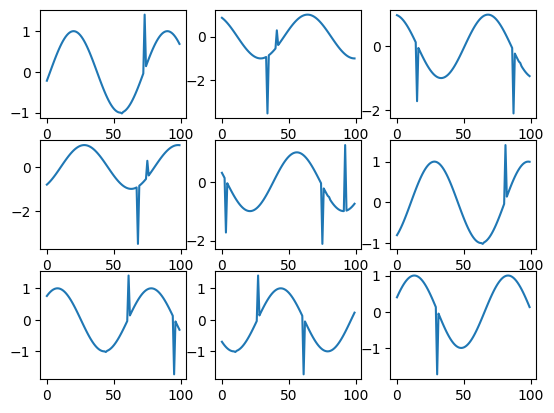

In [5]:
x_aux=next(iter(dataloader))
x_aux=x_aux.cpu().detach().numpy()
print(x_aux.shape)
for i in range(9):
    plt.subplot(3,3,1+i)
    plt.plot(x_aux[i])

In [27]:


class AnomalyModel:
    def __init__(self, AnomalyTransformer, dataset, batch_size=16,window_size=100,enc_in=1,enc_out=1, d_model=64, n_heads=2, e_layers=2, d_ff=32,
                 dropout=0.1, activation='relu',  lambda_=1e-3):
        self.model = AnomalyTransformer(window_size, enc_in, enc_out, d_model, n_heads, e_layers, d_ff, dropout, activation, output_attention=True)
        self.model.cuda()
        self.model = self.xavier_initialization(self.model)
        self.dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
        self.lambda_ = lambda_

    @staticmethod
    def xavier_initialization(model):
        for module in model.modules():
            if hasattr(module, 'weight') and module.weight is not None and module.weight.dim() >= 2:
                nn.init.xavier_uniform_(module.weight)
                if hasattr(module, 'bias') and module.bias is not None:
                    nn.init.constant_(module.bias, 0)
        return model

    @staticmethod
    def my_kl_loss(p, q):
        res = p * (torch.log(p + 0.0001) - torch.log(q + 0.0001))
        return torch.mean(torch.sum(res, dim=-1), dim=1)

    @staticmethod
    def layer_association_discrepancy(Pl, Sl):
        B, Head, Height, _ = Pl.shape
        kl1 = AnomalyModel.my_kl_loss(Pl.view(B, Head, Height, -1), Sl.view(B, Head, Height, -1))
        kl2 = AnomalyModel.my_kl_loss(Sl.view(B, Head, Height, -1), Pl.view(B, Head, Height, -1))
        ad_vector = kl1 + kl2
        return ad_vector

    @staticmethod
    def association_discrepancy(P_list, S_list):
        return torch.stack([AnomalyModel.layer_association_discrepancy(j/torch.unsqueeze(torch.sum(j, dim=-1), dim=-1).repeat(1, 1, 1, 100),i) for i, j in zip(S_list,P_list)]).mean(axis=[0])

    @staticmethod
    def loss_function(x_hat, P_list, S_list, lambda_, x):
        frob_norm = ((x_hat - x)**2).mean()
        diss_norm = torch.mean(AnomalyModel.association_discrepancy(P_list, S_list))
        print(frob_norm, diss_norm)
        return (frob_norm.item(), diss_norm.item()), frob_norm - (lambda_ * diss_norm)

    @staticmethod
    def min_loss(output, P_layers, S_layers, x, lambda_):
        P_list = P_layers
        S_list = [S.detach() for S in S_layers]
        lambda_ = -lambda_
        _, loss_value = AnomalyModel.loss_function(output, P_list, S_list, lambda_, x)
        return loss_value

    @staticmethod
    def max_loss(output, P_layers, S_layers, x, lambda_):
        P_list = [P.detach() for P in P_layers]
        S_list = S_layers
        lambda_ = lambda_
        details, loss_value = AnomalyModel.loss_function(output, P_list, S_list, lambda_, x)
        return details, loss_value
    
    def cosine_lr_schedule_with_warmup(self, optimizer, epoch, initial_lr, total_epochs, warmup_epochs):
        if epoch < warmup_epochs:
            lr = initial_lr * (epoch + 1) / warmup_epochs
        else:
            adjusted_epoch = epoch - warmup_epochs
            adjusted_total_epochs = total_epochs - warmup_epochs
            lr = 0.5 * initial_lr * (1 + math.cos(math.pi * adjusted_epoch / adjusted_total_epochs))

        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

    def train(self, num_epochs, initial_lr, warmup_epochs):
        optimizer = optim.Adam(self.model.parameters(), lr=initial_lr)

        self.model.train()
        loss_frob_diss = []

        for epoch in range(num_epochs):
            print(f"Epoch: {epoch}")
            for i, (inputs) in enumerate(self.dataloader):
                inputs = inputs.float().to("cuda:0")
                outputs, series, prior, _ = self.model(inputs)
                prior = [j / torch.unsqueeze(torch.sum(j, dim=-1), dim=-1).repeat(1, 1, 1, 100) for j in prior]

                loss_min = self.min_loss(outputs, prior, series, inputs, self.lambda_)
                details, loss_max = self.max_loss(outputs, prior, series, inputs, self.lambda_)
                loss_frob_diss.append(list(details))

                loss_min.backward(retain_graph=True)
                loss_max.backward()

                optimizer.step()
                optimizer.zero_grad()

                self.cosine_lr_schedule_with_warmup(optimizer, epoch, initial_lr, num_epochs, warmup_epochs)
                print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(self.dataloader)}], Loss: {loss_max.item():.4f}")

        print("Entrenamiento finalizado")
        return np.array(loss_frob_diss)
    
    def predict(self, data=None):
        if data is None:
            data = next(iter(self.dataloader)).float().to("cuda:0")
        else:
            data = torch.tensor(data).float()
            data = data.unsqueeze(0).to("cuda:0")

        self.model.eval()
        with torch.no_grad():
            out, series, prior, sigmas = self.model(data)

        out = out.cpu().numpy()
        series = [s.cpu().numpy() for s in series]
        prior = [p.cpu().numpy() for p in prior]
        sigmas = [sigma.cpu().numpy() for sigma in sigmas]

        return data.cpu().detach().numpy(),out, series, prior, sigmas



In [28]:

# Instanciar la clase AnomalyModel con el conjunto de datos creado
dataset = Data_anomSine(length=400, sf=0.01, f=0.007, phase=4, anoms=11, magnitud=1.5)

model_instance = AnomalyModel(AnomalyTransformer.AnomalyTransformer, dataset)

# Parámetros de entrenamiento
num_epochs = 100
initial_lr = 0.001
warmup_epochs = 10

# Entrenar la instancia de la clase AnomalyModel

loss_frob_diss = model_instance.train(num_epochs, initial_lr, warmup_epochs)

# Ahora puedes usar 'model_instance' para hacer predicciones utilizando el método 'predict'


Epoch: 0
tensor(3.0411, device='cuda:0', grad_fn=<MeanBackward0>) tensor(8.9395, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(3.0411, device='cuda:0', grad_fn=<MeanBackward0>) tensor(8.9395, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [1/100], Step [1/19], Loss: 3.0322
tensor(1.3626, device='cuda:0', grad_fn=<MeanBackward0>) tensor(8.9129, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.3626, device='cuda:0', grad_fn=<MeanBackward0>) tensor(8.9129, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [1/100], Step [2/19], Loss: 1.3537
tensor(1.2491, device='cuda:0', grad_fn=<MeanBackward0>) tensor(8.9134, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.2491, device='cuda:0', grad_fn=<MeanBackward0>) tensor(8.9134, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [1/100], Step [3/19], Loss: 1.2402
tensor(1.2915, device='cuda:0', grad_fn=<MeanBackward0>) tensor(8.9108, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.2915, device='cuda:0', grad_fn=<MeanBackward0>) tensor(8.9108

In [36]:
dat,out, series, prior, sigmas=model_instance.predict()

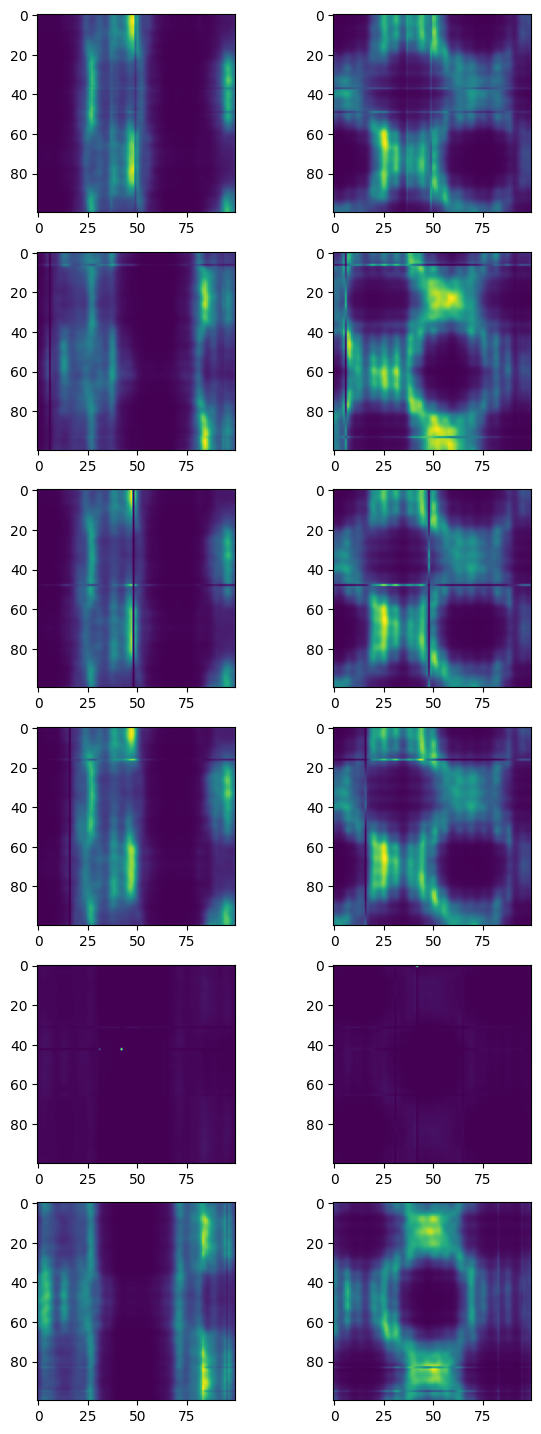

In [37]:
#plot el asociation
plt.figure(figsize=(7,18))
for i in range(6):
    plt.subplot(6,2,i*2+1)
    plt.imshow(series[1][i,0])
    plt.subplot(6,2,i*2+2)
    plt.imshow(series[1][i,1])

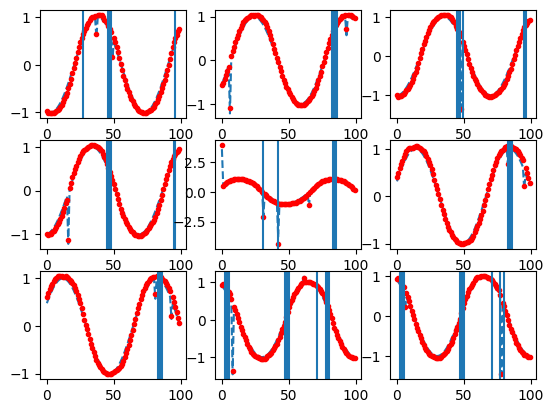

In [38]:
for j in range(9):
    plt.subplot(3,3,j+1)
    a=series[1][j,0]
    indx=np.unique(np.argwhere(a>np.percentile(a,99))[:,1])
    plt.plot(dat[j],"--")
    plt.plot(out[j],".r")
    for i in indx:
        plt.axvline(i)

(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

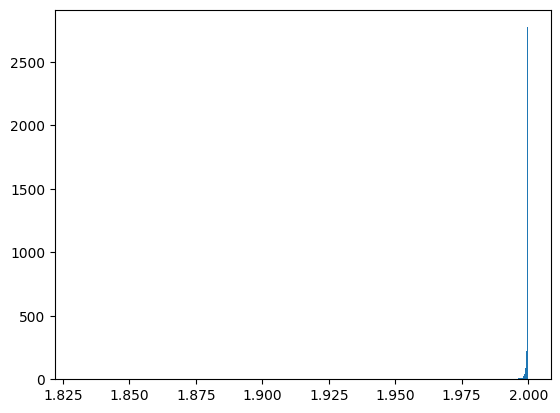

In [39]:
plt.hist(sigmas[0][:,:,:,0].flatten(),bins=400)